Author: Pascal, pascal@bayesimpact.org

Date: 2018-06-18

# ROME update from v334 to v335

In June 2018 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

One change that we noted during the preparation of this notebook was that the typo `Conductrcie` instead of `Conductrice` has finally been fixed!

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v335. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '334'
NEW_VERSION = '335'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


So we have the same set of files in both versions: good start.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=pd.read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=pd.read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

All files have the same columns as before: still good.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

99/30819 values added in unix_coherence_item_v335_utf8.csv
15/11692 values added in unix_cr_gd_dp_appellations_v335_utf8.csv
792/1992 values added in unix_item_arborescence_v335_utf8.csv
31/13387 values removed in unix_item_v335_utf8.csv
114/42387 values added in unix_liens_rome_referentiels_v335_utf8.csv
10/7406 values added in unix_referentiel_activite_riasec_v335_utf8.csv
10/9142 values added in unix_referentiel_activite_v335_utf8.csv
15/11036 values added in unix_referentiel_appellation_v335_utf8.csv
7/4955 values added in unix_referentiel_competence_v335_utf8.csv
1/4219 values added in unix_rubrique_mobilite_v335_utf8.csv
1/5040 values added in unix_texte_v335_utf8.csv
10/21 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation, item, and liens_rome_referentiels, so let's see more precisely.

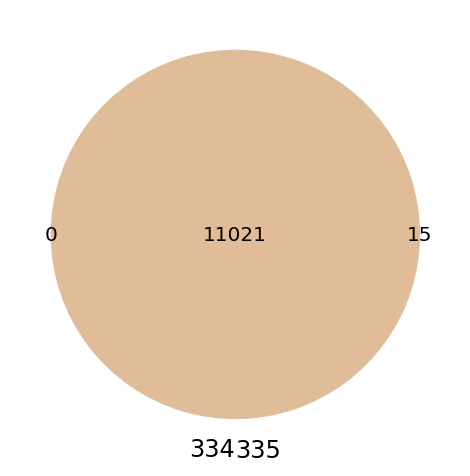

In [6]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 15 new jobs added. Let's take a look (only showing interesting fields):

In [7]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
3885,140914,Concepteur / Conceptrice paysagiste,F1101
3887,140924,"Réparateur / Réparatrice en smartphone, téléphonie mobile, tablette",I1402
3888,140925,Réparateur / Réparatrice en produits de télécommunication et multimédia,I1402
3889,140927,Cuviste,A1413
3890,140928,Groom chevaux,A1501
3891,140929,Vendeur / Vendeuse en cigarettes électroniques,D1211
3893,140930,Consultant / Consultante tourisme,G1102
3894,140931,Opérateur / Opératrice en vidéoprotection,K2503
3895,140934,Ingénieur / Ingénieure d''affaires industrielles en éco-conception,H1102
3896,140935,Ingénieur / Ingénieure ERD en éco-conception produits,H1206


They mostly seem to be new jobs: DPO, ecology engineers, e-cigarette retailer.

OK, let's check at the changes in items:

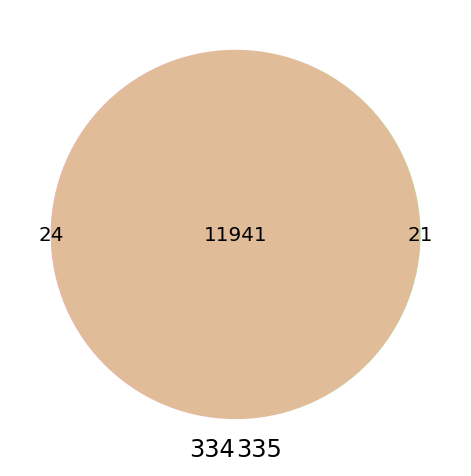

In [8]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): some items are now obsolete and new ones have been created. Let's have a look at them.

In [9]:
display(items.old[items.old.code_ogr.isin(obsolete_items)].head())
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
1872,104371,Intervenir en instrumentation,2,9,NaN,NaN,NaN
2020,104670,Intervenir en dispatching,2,9,NaN,NaN,NaN
4049,108002,"Réaliser des interventions en pharmacie, biologie médicale",2,9,NaN,NaN,NaN
4050,108004,Réaliser des interventions en soins vétérinaires,2,9,NaN,NaN,NaN
6795,118218,"Techniques de bureautique, administratif",1,10,NaN,NaN,NaN


,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
5946,115876,Analyse du Cycle de Vie - ACV des produits,1,10,NaN,NaN,NaN
5947,115876,Analyse du Cycle de Vie - ACV des produits,1,7,NaN,NaN,NaN
6661,118051,Économie internationale,1,10,NaN,NaN,NaN
11953,125772,Réaliser une étude d''impact environnemental,2,9,NaN,NaN,NaN
12030,125864,Définir les critères d''analyse de l''expérience utilisateur,2,9,NaN,NaN,NaN


The new ones seem legit to me. The old ones, though, don't feel obsolete. I'm going to trust the ROME makers as it's a small change anyway.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [10]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added      122
removed     31
Name: _diff, dtype: int64

So in addition to the added and removed items, there are few fixes. Let's have a look at them:

In [11]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(5)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
1334,E1105,117296,left_only,removed,Coordination d''édition,Rechercher des auteurs pour des traductions
3400,A1203,104514,left_only,removed,Aménagement et entretien des espaces verts,Mécanique
3421,A1203,123665,left_only,removed,Aménagement et entretien des espaces verts,Réaliser des petits ouvrages de maçonnerie
7724,I1102,103203,left_only,removed,Management et ingénierie de maintenance industrielle,"Intervenir en acoustique, thermique"
7725,I1102,103209,left_only,removed,Management et ingénierie de maintenance industrielle,Intervenir dans le domaine hydraulique


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
30656,D1205,124888,right_only,added,Nettoyage d''articles textiles ou cuirs,Entretenir des équipements
30657,E1303,119364,right_only,added,Encadrement des industries graphiques,Contrôler la conformité d''une production
30658,A1203,100057,right_only,added,Aménagement et entretien des espaces verts,Techniques de préservation de la biodiversité
30659,A1203,103503,right_only,added,Aménagement et entretien des espaces verts,Domotique
30660,A1203,103771,right_only,added,Aménagement et entretien des espaces verts,Réaliser et poser les coffrages et couler les éléments en béton


Those fixes make sense (not sure why they were not done before, but let's not complain: it is fixed now).

Finally let's check the changes in the main table `referentiel_code_rome` to make sure nothing big changed. First let's join the old and the new table in one dataset:

In [12]:
code_rome = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome')
code_rome_diff = pd.merge(code_rome.old, code_rome.new, on='code_rome', suffixes=('_old', '_new'))
code_rome_diff.head()

,code_rome,code_fiche_em_old,code_ogr_old,libelle_rome_old,statut_old,code_fiche_em_new,code_ogr_new,libelle_rome_new,statut_new
0,A1204,13,10,Protection du patrimoine naturel,1,13,10,Protection du patrimoine naturel,1
1,D1214,97,100,Vente en habillement et accessoires de la personne,1,97,100,Vente en habillement et accessoires de la personne,1
2,D1301,120,101,Management de magasin de détail,1,120,101,Management de magasin de détail,1
3,D1401,125,102,Assistanat commercial,1,125,102,Assistanat commercial,1
4,D1402,124,103,Relation commerciale grands comptes et entreprises,1,124,103,Relation commerciale grands comptes et entreprises,1


And now let's see the differences:

In [13]:
code_rome_diff[
    (code_rome_diff.code_fiche_em_old != code_rome_diff.code_fiche_em_new) |
    (code_rome_diff.code_ogr_old != code_rome_diff.code_ogr_new) |
    (code_rome_diff.libelle_rome_old != code_rome_diff.libelle_rome_new) |
    (code_rome_diff.statut_old != code_rome_diff.statut_new)
]

,code_rome,code_fiche_em_old,code_ogr_old,libelle_rome_old,statut_old,code_fiche_em_new,code_ogr_new,libelle_rome_new,statut_new
47,F1101,161,142,Architecture du BTP,1,161,142,Architecture du BTP et du paysage,1
50,F1104,163,145,Dessin BTP,1,163,145,Dessin BTP et paysage,1
56,F1201,178,150,Conduite de travaux du BTP,1,178,150,Conduite de travaux du BTP et de travaux paysagers,1
245,I1402,271,321,Réparation de biens électrodomestiques,1,271,321,Réparation de biens électrodomestiques et multimédia,1
521,A1203,16,9,Entretien des espaces verts,1,16,9,Aménagement et entretien des espaces verts,1


OK, only 5 lines have be changed: only their names has changed. Jobs about constructions are now also about landscapes. And a slight rephrasing for two others. Not a big deal for us.

# Conclusion

The new version of ROME, v335, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf). The transition should be transparent with a very small advantage over the old version.